<div style="text-align: center;">
<h1> Seminar 1: Optimizing Conference Paper </h1> <vid>
<h2>Assignment Using Genetic Algorithms </h2> <div>
<h4>Intelligent Systems <div>
October 28, 2024 <h4>
</div>

<h5>The goal of Seminar 1. is to maximize reviewer satisfaction by aligning assignments with their preferences while adhering to key constraints. These constraints include balancing the workload among reviewers, ensuring each paper receives adequate reviews, avoiding conflicts of interest such as friendships or authorship, and maintaining fairness and efficiency.   <div>
The first task we faced was deciding which constraints to include in the fitness function. After attempting to solve the easy_dataset_1 and discovering it was impossible to satisfy all conditions simultaneously, we chose to incorporate the primary constraints into the fitness function with varying weights, rather than validating each child after crossover. <div>
At the beginning, we tested the fitness of our solution using built-in functions from the PyGAD library. This allowed us to select parameters that would work well for this specific problem.
</h5> 

##### **Imports**

In [2]:
import numpy as np
import pygad
import random
import json
import itertools
import matplotlib.pyplot as plt
import os
import time


##### **Dataset Class with print functions, different mutation functions, crossover functions, ...**

In [3]:
class Dataset:
    # get all the data fom the json file
    def __init__(self, data):
        self.num_papers = data.get('num_papers', None)
        self.num_reviewers = data.get('num_reviewers', None)
        self.reviewer_capacity = data.get('reviewer_capacity', None)
        self.min_reviews_per_paper = data.get('min_reviews_per_paper', None)
        self.max_reviews_per_paper = data.get('max_reviews_per_paper', None)
        self.num_generations = 100
        self.population_size = 50
        self.num_parents_mating = 20 
        self.P = np.array(data.get('preferences', None))
        self.F = np.array(data.get('friendships', None))
        self.A = np.array(data.get('authorship', None))
        self.initial_pop = self.make_initial_population()
        self.fitness_penalty = fitnes_penalty = {
                "friends": 500,
                "authorship": 150,
                "min_reviews": 5,
                "max_reviews":80,
                "reviewer_capacity": 90
            }
        self.fitness_function = self.create_fitness_function_basic()
        self.costum_mutation = self.create_costum_mutation()
        self.solution_is_valid = self.create_solution_is_valid()
        self.custom_crossover = self.create_custom_crossover()
        self.fitness_function_advanced = self.create_fitness_function_advanced()

    # make the initial population
    def make_initial_population(self):
        population = np.random.randint(0, 2, size=(self.population_size,self.num_reviewers * self.num_papers))
        return population
    
    # change parameters
    def change_population_size(self, population_size):
        self.population_size = population_size
    def change_num_generations(self, num_generations):
        self.num_generations = num_generations
    def change_num_parents_mating(self, num_parents_mating):
        self.num_parents_mating = num_parents_mating
    def change_fitnes_penalty(self, name, value):
        self.fitnes_penalty[name] = value
        
    # fitness functions
    def create_fitness_function_basic(self):
        def fitness_func_basic(ga_instance, solution, solution_idx):
            preference_score = np.sum(solution * self.P.flatten())
            penalty = 0
            penalty += np.sum(solution * self.A.flatten()) * self.fitness_penalty["authorship"]
            reshaped_sol = solution.reshape((self.num_reviewers, self.num_papers))
            per_reviewer = np.sum(reshaped_sol, axis=1)
            per_paper = np.sum(reshaped_sol, axis=0)
            penalty += np.sum(per_paper < self.min_reviews_per_paper) * self.fitness_penalty["min_reviews"]
            penalty += np.sum(per_paper > self.max_reviews_per_paper) * self.fitness_penalty["max_reviews"]
            penalty += np.sum(per_reviewer > self.reviewer_capacity) * self.fitness_penalty["reviewer_capacity"]
            co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
            friend_review_counts = self.F * co_review_matrix
            penalty += np.sum(friend_review_counts) // 2 * self.fitness_penalty["friends"]

            return preference_score - penalty
        return fitness_func_basic
    
    def create_fitness_function_advanced(self):
        def fitness_func_advanced(ga_instance, solution, solution_idx):
            preference_score = np.sum(solution * self.P.flatten())
            penalty = 0
            penalty += np.sum(solution * self.A.flatten()) * self.fitness_penalty["authorship"]
            reshaped_sol = solution.reshape((self.num_reviewers, self.num_papers))
            per_reviewer = np.sum(reshaped_sol, axis=1)
            per_paper = np.sum(reshaped_sol, axis=0)
            penalty += np.sum(per_paper < self.min_reviews_per_paper) * self.fitness_penalty["min_reviews"]
            penalty += np.sum(per_paper > self.max_reviews_per_paper) * self.fitness_penalty["max_reviews"]
            penalty += np.sum(per_reviewer > self.reviewer_capacity) * self.fitness_penalty["reviewer_capacity"]
            co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
            friend_review_counts = self.F * co_review_matrix
            penalty += np.sum(friend_review_counts) // 2 * self.fitness_penalty["friends"]

            authored_papers_by_friends = np.dot(self.F, self.A)
            penalty_matrix = reshaped_sol * authored_papers_by_friends
            penalty += np.sum(penalty_matrix) * self.fitness_penalty["friends"]

            return preference_score - penalty
        return fitness_func_advanced
    
    # mutation function
    def create_costum_mutation(self):
        def custom__single_point_mutation(offspring, ga_instance):
            number_tries = 10
            for idx in range(offspring.shape[0]):
                solution_is_valid_func = self.create_solution_is_valid()
            
                initial_vector_constrains = solution_is_valid_func(
                    offspring[idx], get_sum=False, print_values=False, return_matrix=True
                )
                constraint_vector = np.array([1 if val == 0 else 0 for val in initial_vector_constrains])
                
                number_mutations = offspring.shape[1] 
                number_tries = 10
                #random_choice = random.random() < (2 / 3)
                while number_tries > 0:
                    gene_idx = np.random.randint(0, offspring.shape[1])
                    offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
                    
                    new_constraint_vector = solution_is_valid_func(
                        offspring[idx], get_sum=False, print_values=False, return_matrix=True
                    )
                    
                    if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                        number_tries = 0 
                    else:
                        offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
                        number_tries -= 1
            if(number_tries != 0):
                print("Mutation failed",number_mutations," times",number_tries)
            return offspring
        return custom__single_point_mutation
    
    # crossover function
    def create_custom_crossover(self):
        def custom_crossover_funct(parents, offspring_size, ga_instance):

            offspring = []
            idx = 0
            solution_is_valid_func = self.create_solution_is_valid()
            
            while len(offspring) != offspring_size[0]:
                number_tries = 5
                parent1 = parents[idx % parents.shape[0], :].copy()
                parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
                vect_1 = solution_is_valid_func(parent1, get_sum=False, print_values=False, return_matrix=True)
                vect_2 = solution_is_valid_func(parent2, get_sum=False, print_values=False, return_matrix=True)
                best = vect_1
                if np.sum(vect_1) > np.sum(vect_2):
                    best = vect_2 
               # random_choice = random.random() < (2 / 3)
                while(number_tries > 0):
                    random_split_point = np.random.choice(range(offspring_size[1]))
                    new_offspring = parent1.copy()
                    new_offspring[random_split_point:] = parent2[random_split_point:]
                    new_constraint_vector = solution_is_valid_func(new_offspring, get_sum=False, print_values=False, return_matrix=True)
                    constraint_vector = np.array([1 if val == 0 else 0 for val in best])
                    if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                        offspring.append(new_offspring)
                        number_tries = 0
                        break
                    number_tries -= 1
                    if number_tries == 0:
                        offspring.append(new_offspring)
                idx += 1
            return np.array(offspring)
        return custom_crossover_funct
    

    
    def create_solution_is_valid(self):
        def solution_is_valid(solution,get_sum=True,print_values=False,return_coorect=False, return_matrix=False):
            solution = solution.flatten()
            penalty_authorship = 0
            penalty_min_reviews = 0
            penalty_max_reviews = 0
            penalty_reviewer_capacity = 0
            penalty_friends = 0
            penalty_authorship = np.sum(solution * self.A.flatten())
            reshaped_sol = solution.reshape((self.num_reviewers, self.num_papers))
            per_reviewer = np.sum(reshaped_sol, axis=1)
            per_paper = np.sum(reshaped_sol, axis=0)
            penalty_min_reviews = np.sum(per_paper < self.min_reviews_per_paper)
            penalty_max_reviews = np.sum(per_paper > self.max_reviews_per_paper)
            penalty_reviewer_capacity = np.sum(per_reviewer > self.reviewer_capacity)
            co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
            friend_review_counts = self.F * co_review_matrix
            penalty_friends = np.sum(friend_review_counts) // 2
            authored_papers_by_friends = np.dot(self.F, self.A)
            penalty_matrix = reshaped_sol * authored_papers_by_friends
        # penalty_friends += np.sum(penalty_matrix)

            if print_values:
                print("penalty_authorship: ", penalty_authorship)
                print("penalty_min_reviews: ", penalty_min_reviews)
                print("penalty_max_reviews: ", penalty_max_reviews)
                print("penalty_reviewer_capacity: ", penalty_reviewer_capacity)
                print("penalty_friends: ", penalty_friends)
                print("Sum: ", penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
            if return_coorect:
                vector = np.array([penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends])
                return np.where(vector > 1, 1, 0)
            if return_matrix:
                sol = (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
                return np.array(sol)
            if (not get_sum):
                return (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
            else:
                return (penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
        return solution_is_valid
    
    

##### **Making Dataset Objects**

In [4]:
# Path to the datasets folder
datasets_folder = 'datasets'

# List all files in the datasets folder
files = os.listdir(datasets_folder)

# Load each JSON file into the data dictionary
data = {}
for file_name in files:
    if file_name.endswith('.json'):
        file_path = os.path.join(datasets_folder, file_name)
        with open(file_path, 'r') as file:
            file_data = json.load(file)
    data[file_name] = Dataset(file_data)
print(data.keys())


dict_keys(['easy_dataset_1.json', 'easy_dataset_2.json', 'hard_dataset_1.json', 'hard_dataset_2.json', 'hard_dataset_3.json', 'hard_dataset_4.json', 'medium_dataset_1.json', 'medium_dataset_2.json'])


##### **Ploting functions**

In [6]:
def run_ga_and_plot_fitness(dataset_name, param_name, param_values, fitnes_penalty, initial_pop, num_generations, num_parents_mating, population_size, fitness_function, num_reviewers, num_papers):
    fitness_history = {str(value): [] for value in param_values}
    
    for value in param_values:
        ga_params = {
            'num_generations': num_generations,
            'num_parents_mating': num_parents_mating,
            'fitness_func': fitness_function,
            'sol_per_pop': population_size,
            'num_genes': num_reviewers * num_papers,
            'initial_population': initial_pop,
            'crossover_type': "single_point",
            'mutation_probability': 0.05,
            'gene_type': int,
            'gene_space': [0, 1],
            'stop_criteria': "saturate_50",
            'parent_selection_type': "tournament"
        }
        
        if param_name == 'mutation_type':
            ga_params['mutation_type'] = value
        elif param_name == 'mutation_probability':
            ga_params['mutation_probability'] = value
        elif param_name == 'crossover_type':
            ga_params['crossover_type'] = value
        elif param_name == 'parent_selection_type':
            ga_params['parent_selection_type'] = value
        elif param_name == 'num_parents_mating':
            ga_params['num_parents_mating'] = value
        
        ga_instance = pygad.GA(**ga_params)
        
        ga_instance.run()
        fitness_history[str(value)] = ga_instance.best_solutions_fitness
    
    return fitness_history

def run_ga_and_plot_fitness_both(dataset_name, param_name, param_values, param_values2, fitnes_penalty, initial_pop, num_generations, num_parents_mating, population_size, fitness_function, num_reviewers, num_papers):
    fitness_history = {str(value): [] for value in param_values}
    best_sols = []

    for value1, value2 in zip(param_values, param_values2):
        ga_params = {
            'num_generations': num_generations,
            'num_parents_mating': num_parents_mating,
            'fitness_func': fitness_function,
            'sol_per_pop': population_size,
            'num_genes': num_reviewers * num_papers,
            'initial_population': initial_pop,
            'crossover_type': "single_point",
            'mutation_probability': 0.05,
            'gene_type': int,
            'gene_space': [0, 1],
            'stop_criteria': "saturate_50",
            'parent_selection_type': "tournament"
        }
        
        ga_params['mutation_type'] = value2
        ga_params['crossover_type'] = value1

        ga_instance = pygad.GA(**ga_params)
        
        ga_instance.run()
        fitness_history[str(value1)] = ga_instance.best_solutions_fitness
        best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
        best_sols.append(best_solution)
    
    return best_sols, fitness_history

def plot_fitness_histogram(data, change_type ,change_values, custom_mutation = False, custom_crossover= False):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.subplots_adjust(top=0.85)  
    time_per_dataset = {}
    for i, (key, dataset) in enumerate(data.items()):
        start_time = time.time()
        if(custom_mutation):
            costum_mutation = dataset.costum_mutation
            change_values[1] = costum_mutation
        if(custom_crossover):
            custom_crossover = dataset.custom_crossover
            change_values[1] = custom_crossover
        fitness_function = dataset.fitness_function
        fitness_history = run_ga_and_plot_fitness(key, change_type, change_values, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_per_dataset[i] = elapsed_time
        for name in change_values:  
            axes[i // 4, i % 4].plot(fitness_history[str(name)], label=f"Mutation Type: {name}")

        axes[i // 4, i % 4].set_xlabel("Generation")
        axes[i // 4, i % 4].set_ylabel("Fitness")
        axes[i // 4, i % 4].set_title(f"Dataset: {key}")
        

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(change_values))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()

    plt.plot(time_per_dataset.keys(), time_per_dataset.values())
    plt.xlabel("Dataset")
    plt.ylabel("Time (s)")
    plt.title("Time per dataset")
    plt.show()
    


##### **Understanding the parameters of ganetic algorithm**

c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


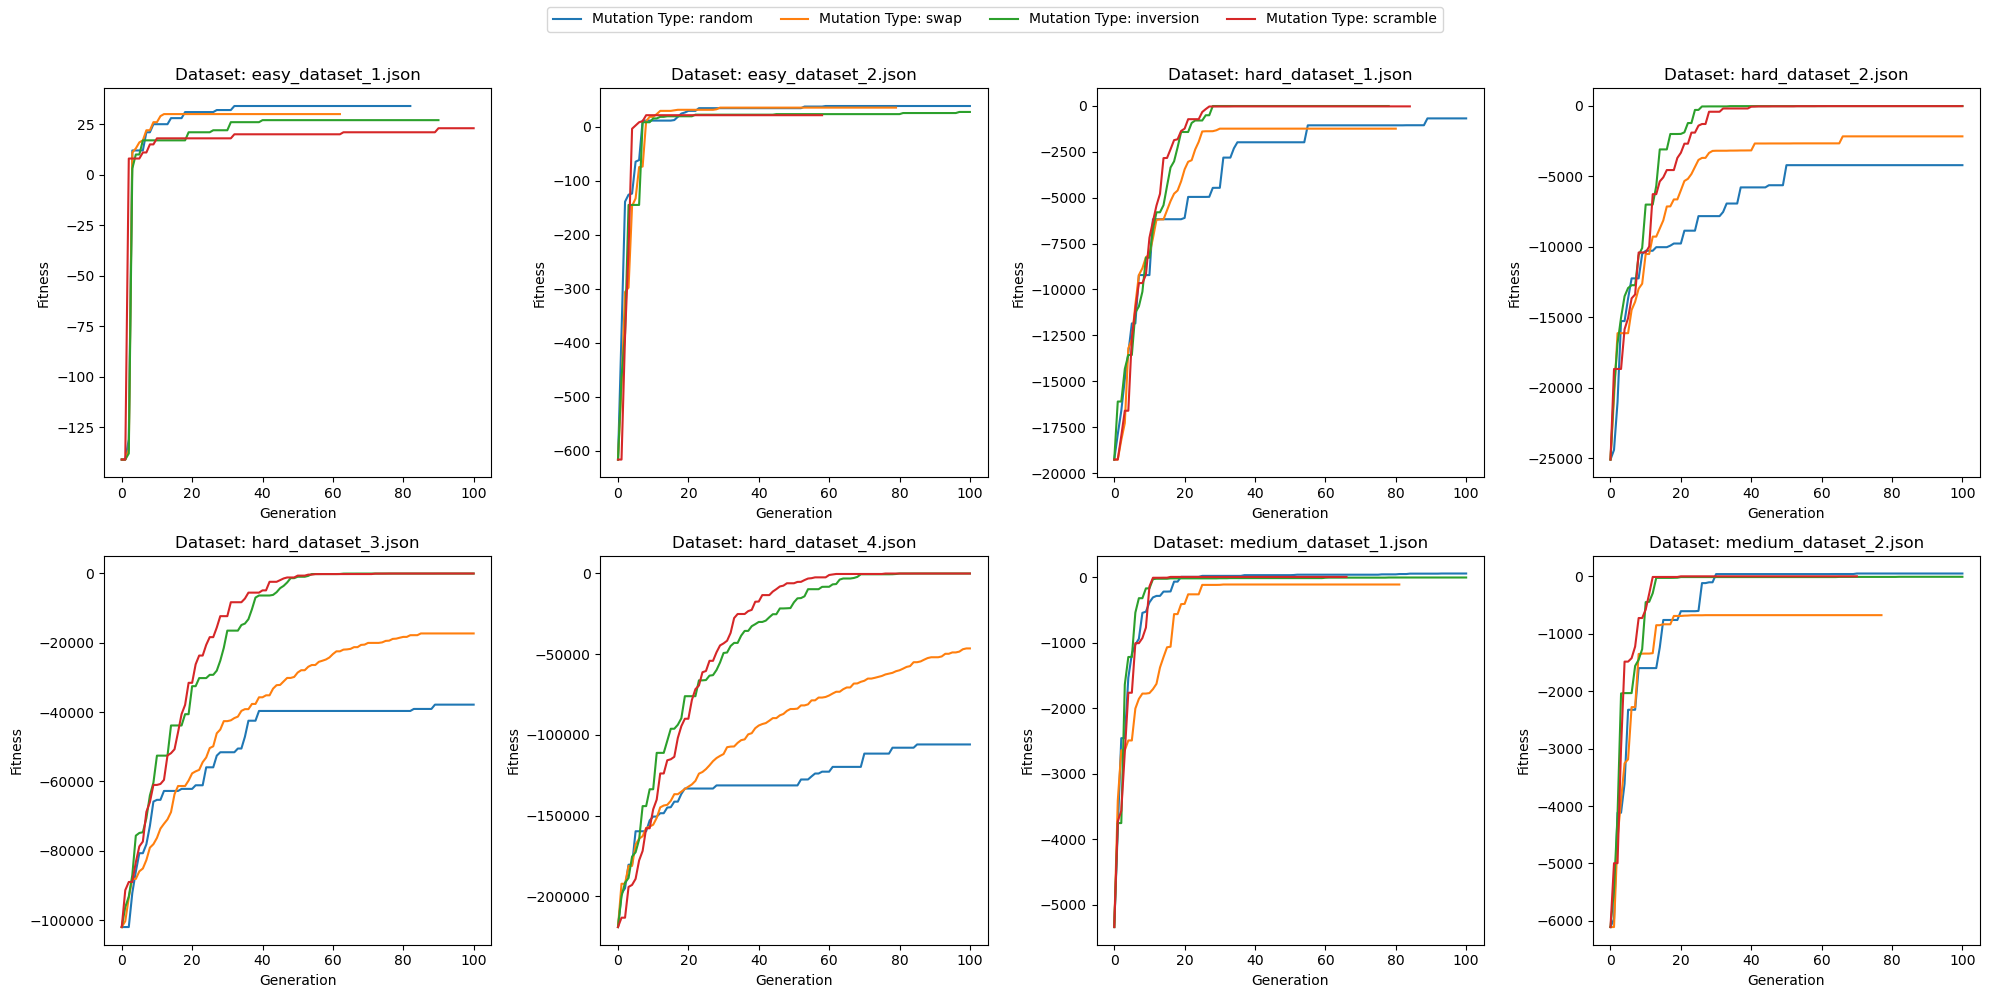

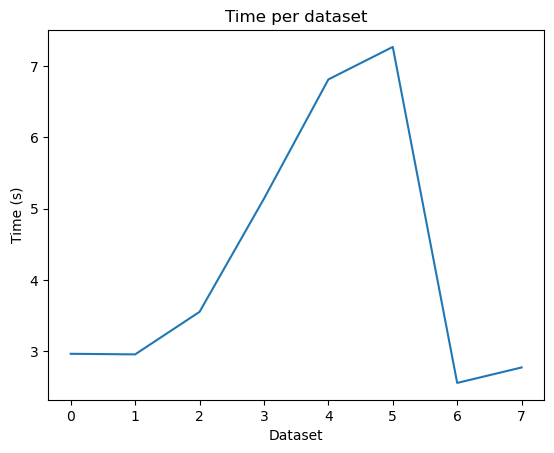

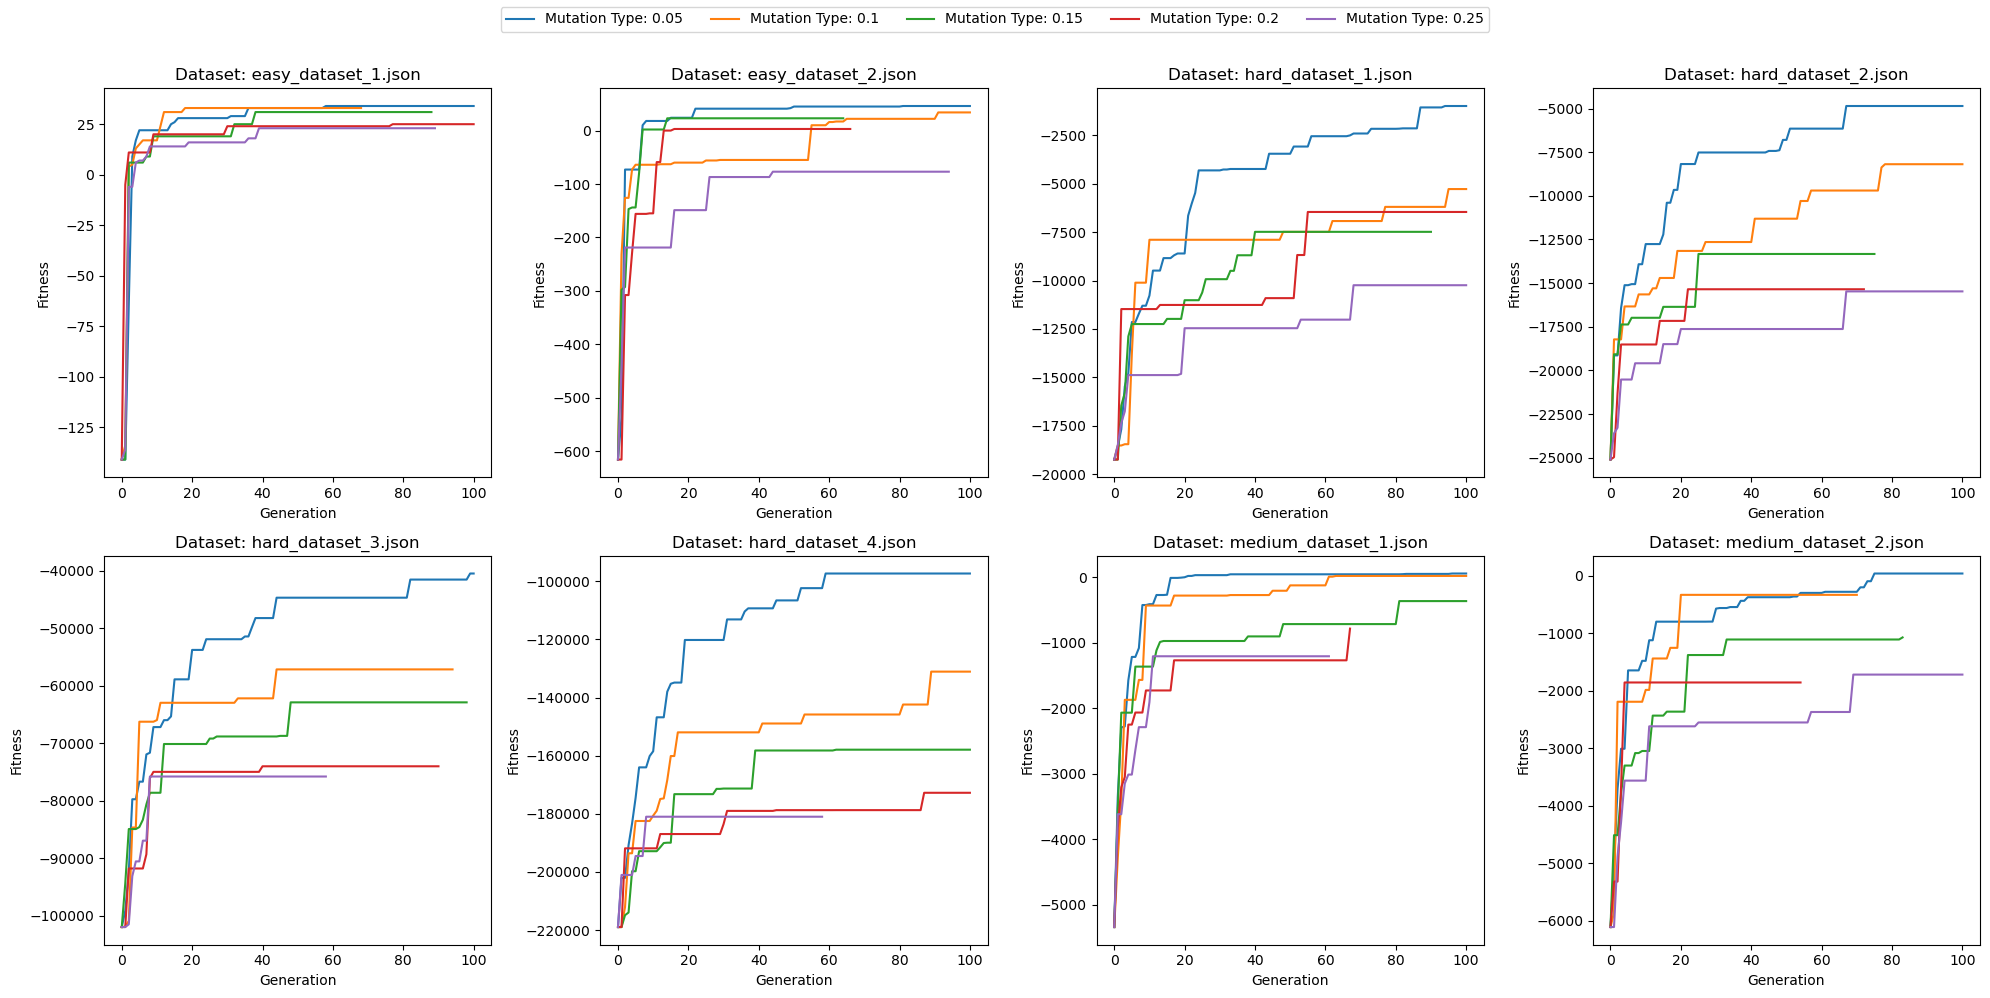

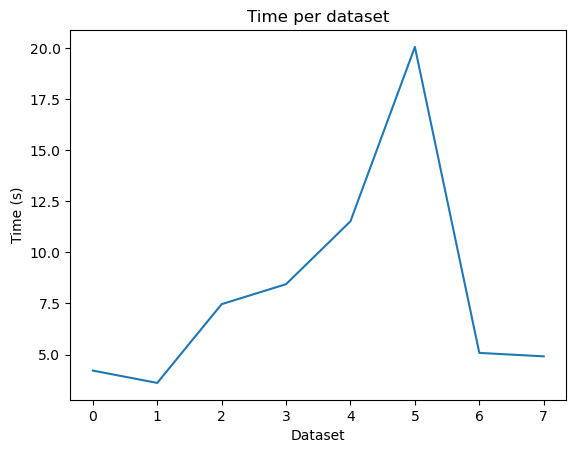

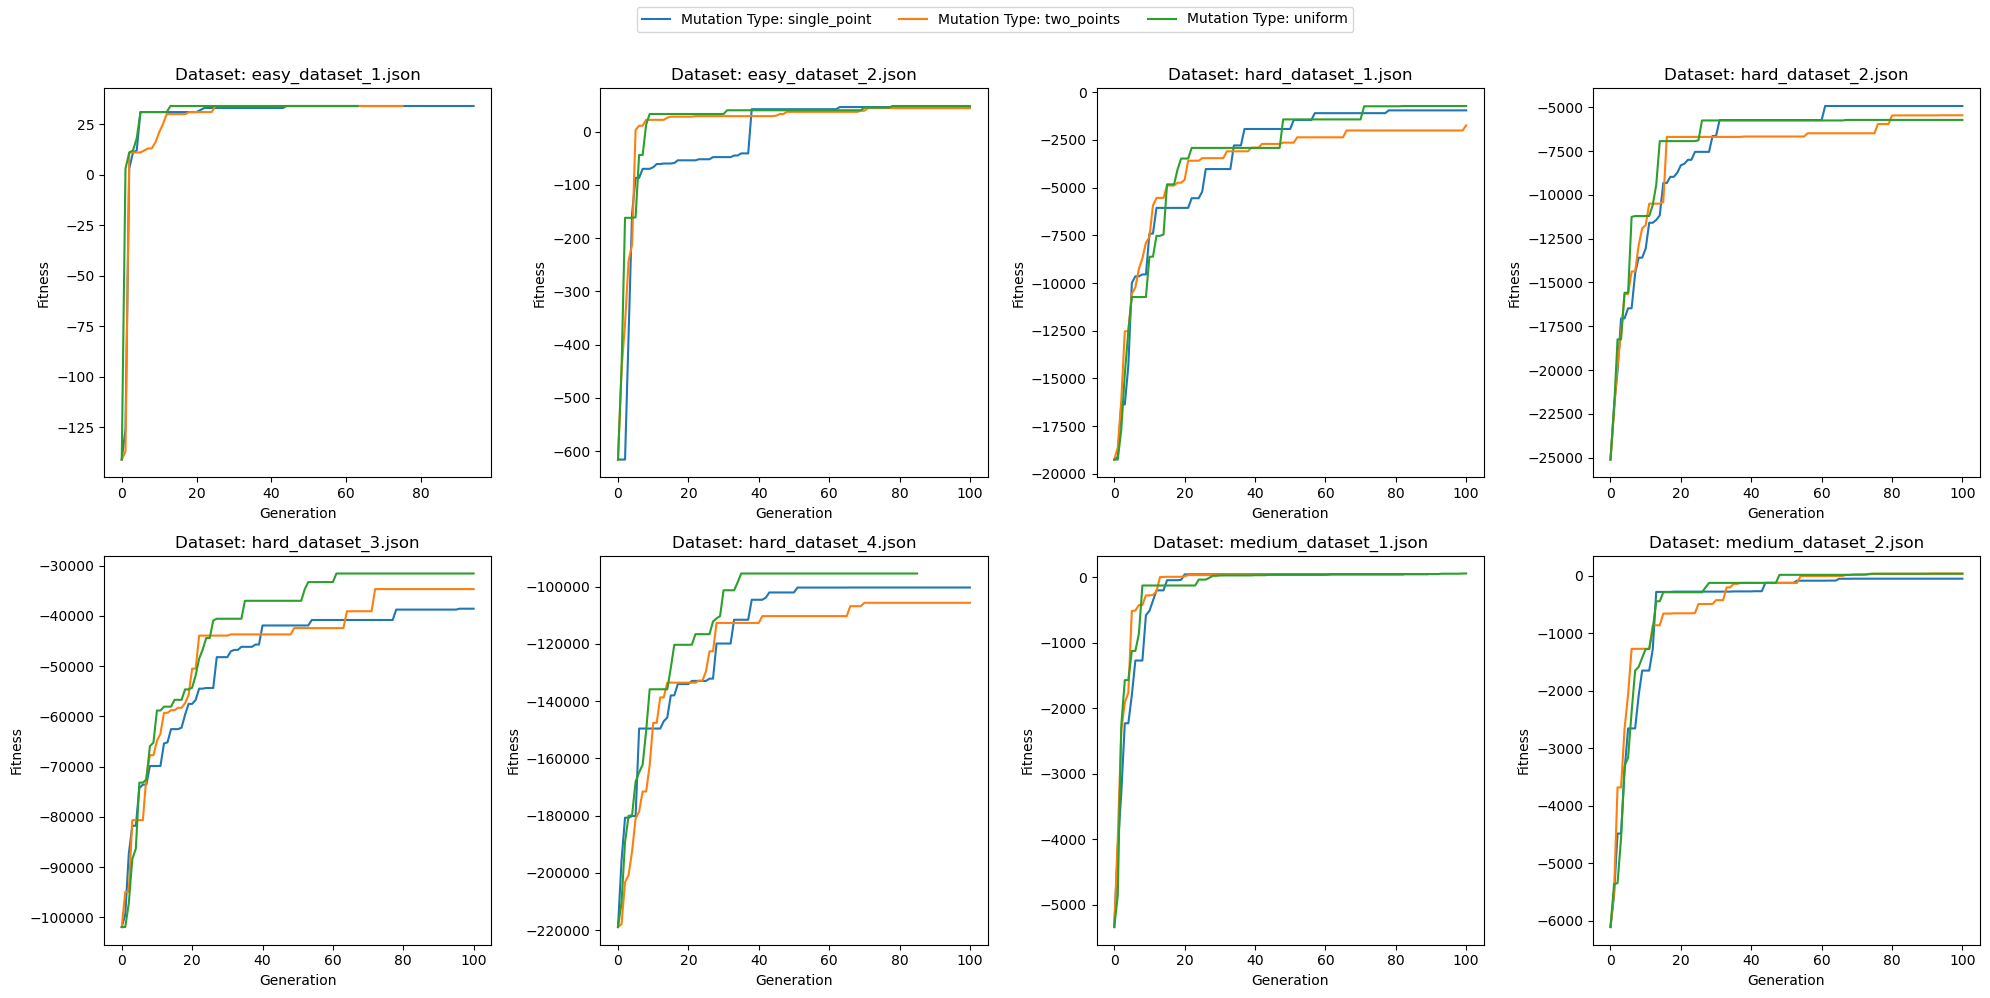

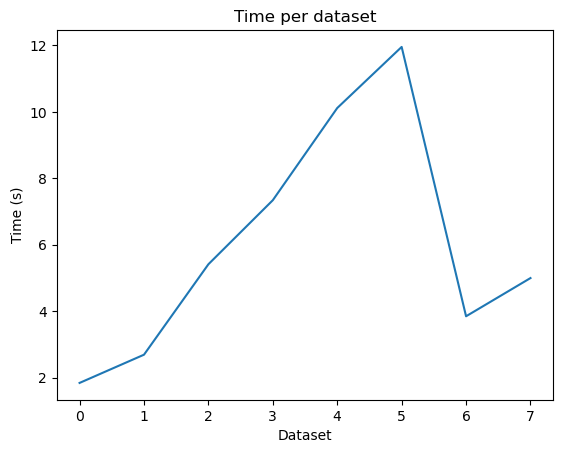

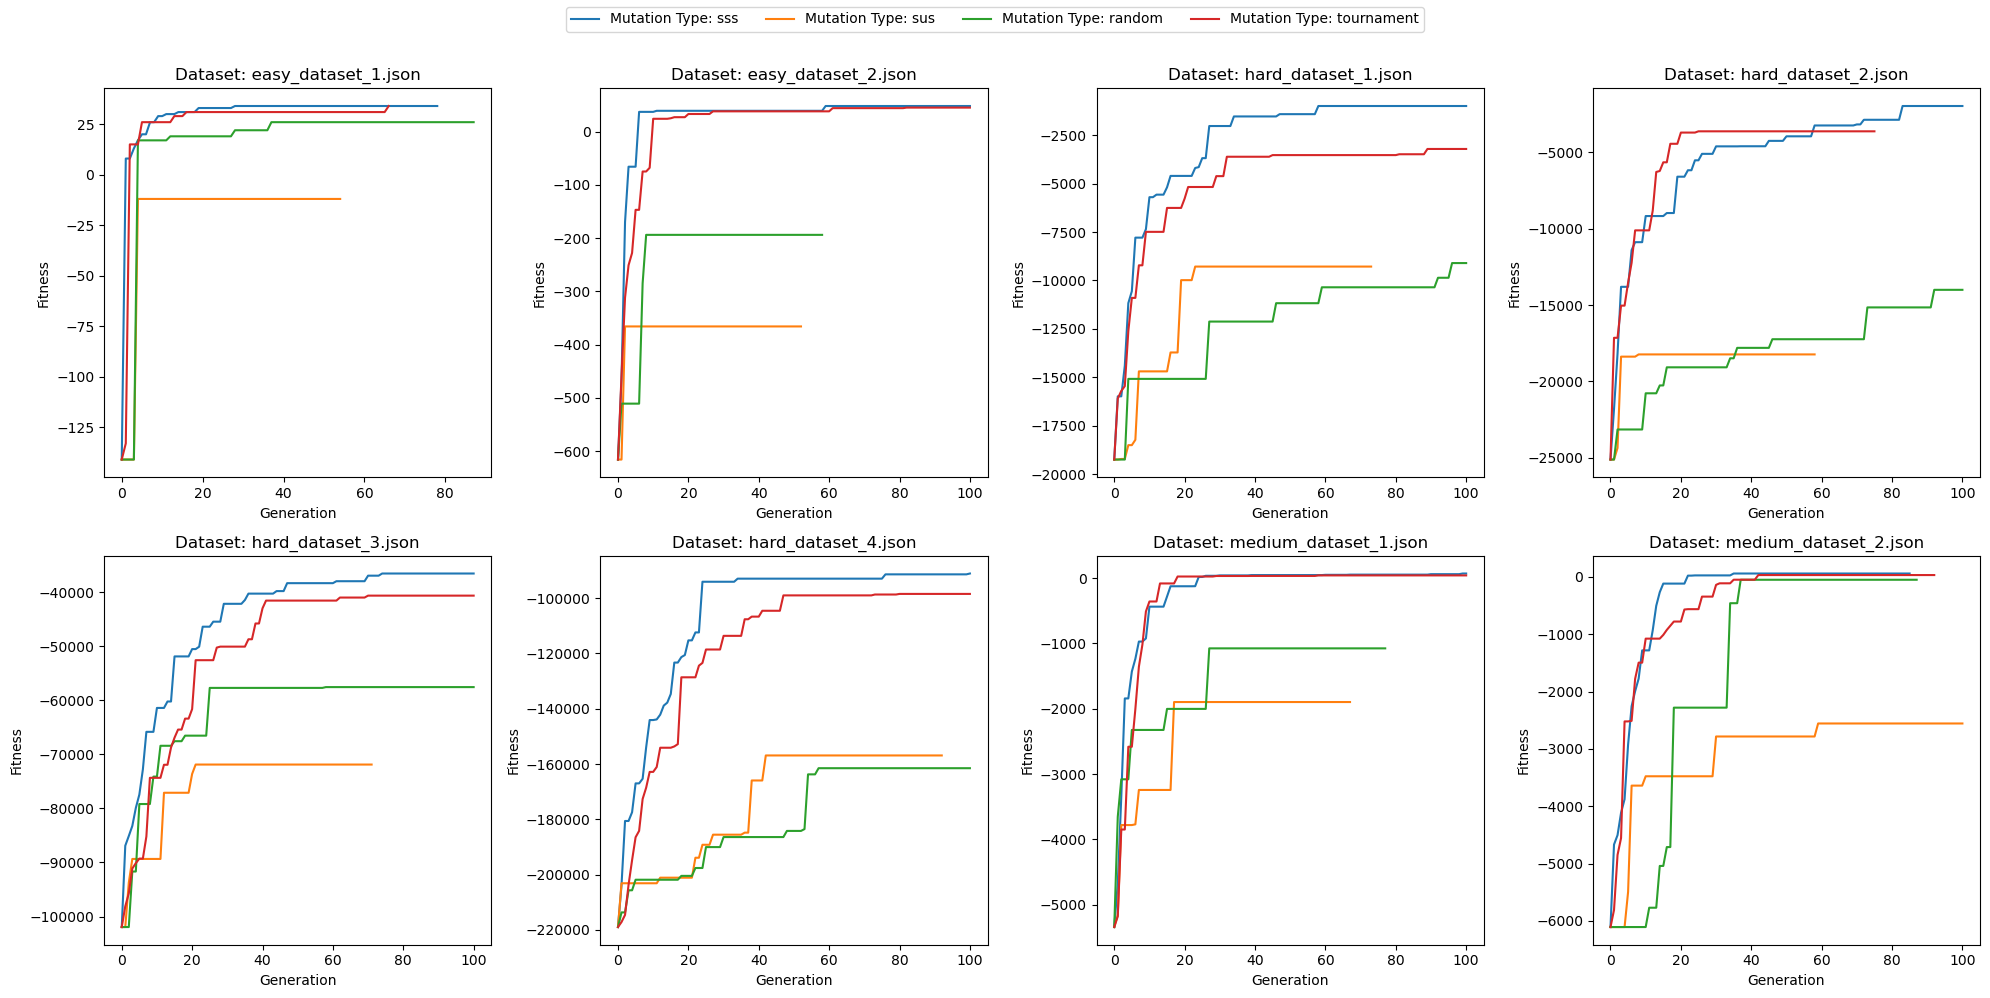

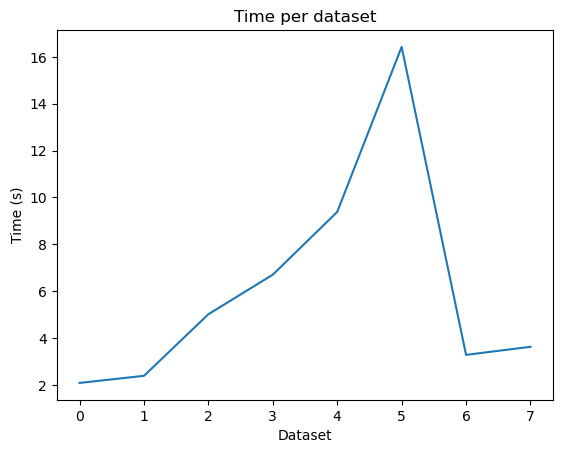

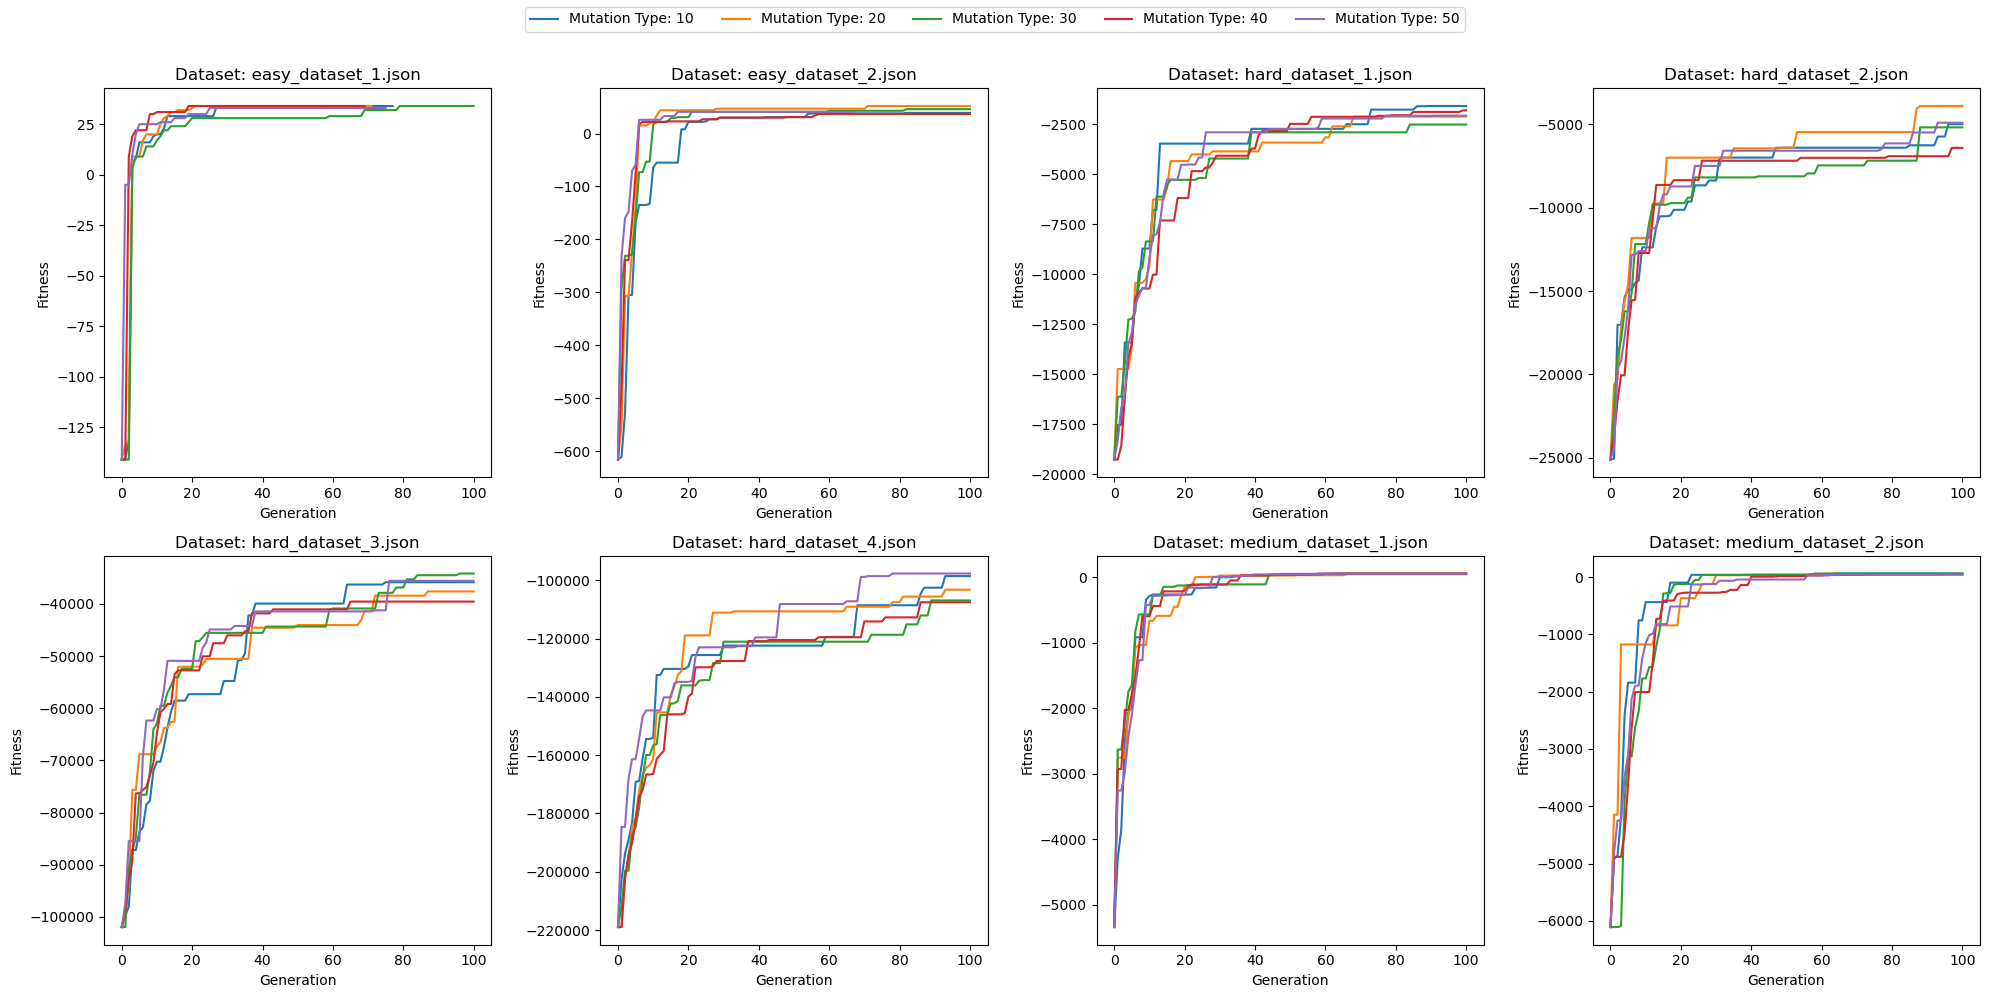

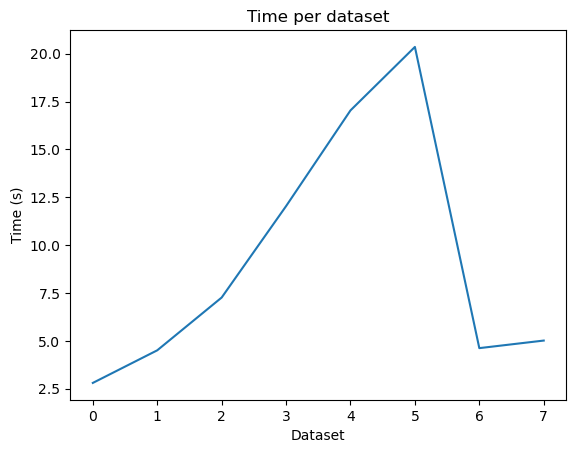

In [112]:

mutation_funcs = ["random", "swap", "inversion", "scramble"]
mutation_names = ["Random", "Swap", "Inversion", "Scramble"]

mutation_rates = [0.05, 0.1, 0.15, 0.2, 0.25]
crossover_types = ["single_point", "two_points", "uniform"]	

parent_selection_types = ["sss", "sus","random", "tournament"]
num_parents_mating_values = [10, 20, 30, 40, 50]

# Create subplots
num_datasets = len(data)


# Mutation Type
plot_fitness_histogram(data, 'mutation_type', mutation_funcs)

# Mutation Probability
plot_fitness_histogram(data, 'mutation_probability', mutation_rates)

# Crossover Type
plot_fitness_histogram(data, 'crossover_type', crossover_types)

# Parent Selection Type
plot_fitness_histogram(data, 'parent_selection_type', parent_selection_types)

# Num Parents Mating
plot_fitness_histogram(data, 'num_parents_mating', num_parents_mating_values)




##### **Best Parameters From Before VS Custom Muataion**
**Custom Mutation**: This is a normal random mutation, where it only makes sure that there are not any new mistakes after the mutation.

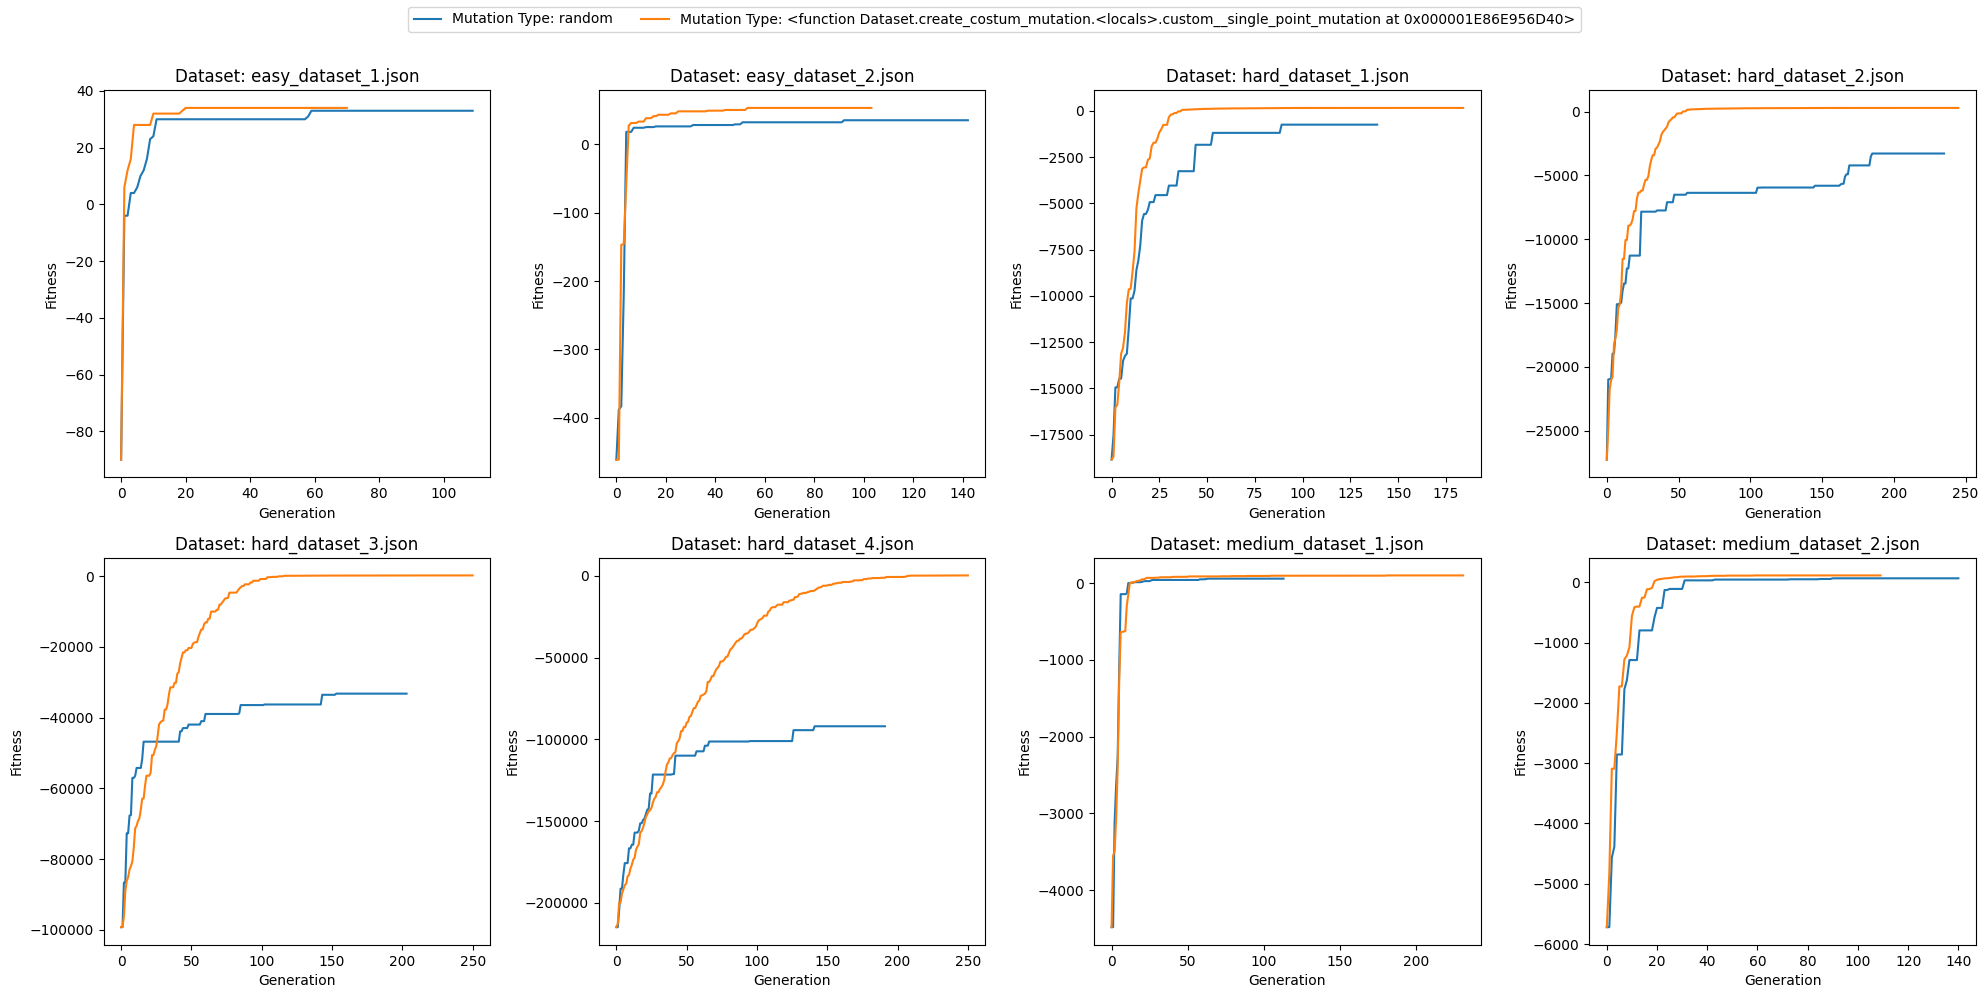

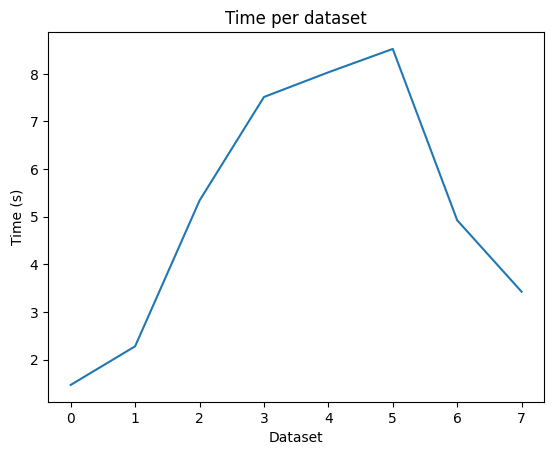

In [14]:

for i, (key, dataset) in enumerate(data.items()):
    dataset.change_population_size(1000) 
    dataset.change_num_generations(250)
mutation_funcs = ["random", None]
plot_fitness_histogram(data, 'mutation_type', mutation_funcs, custom_mutation = True)



##### **Using both custom mutation and crossover functions vs Gat**
**Custom cross-over**: It makes an offspring out of 2 parents based on single point cross-over. It makes sure that there are no new mistakes based on the best individual out of 2 parents.

easy_dataset_1.json
penalty_authorship:  0
penalty_min_reviews:  2
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  0
Sum:  2
penalty_authorship:  0
penalty_min_reviews:  2
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  0
Sum:  2
easy_dataset_2.json
penalty_authorship:  0
penalty_min_reviews:  2
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  0
Sum:  2
penalty_authorship:  0
penalty_min_reviews:  1
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  0
Sum:  1
hard_dataset_1.json
penalty_authorship:  4
penalty_min_reviews:  9
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  2
Sum:  15
penalty_authorship:  0
penalty_min_reviews:  0
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  0
Sum:  0
hard_dataset_2.json
penalty_authorship:  8
penalty_min_reviews:  5
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  6
Sum:  19
penalty_authors

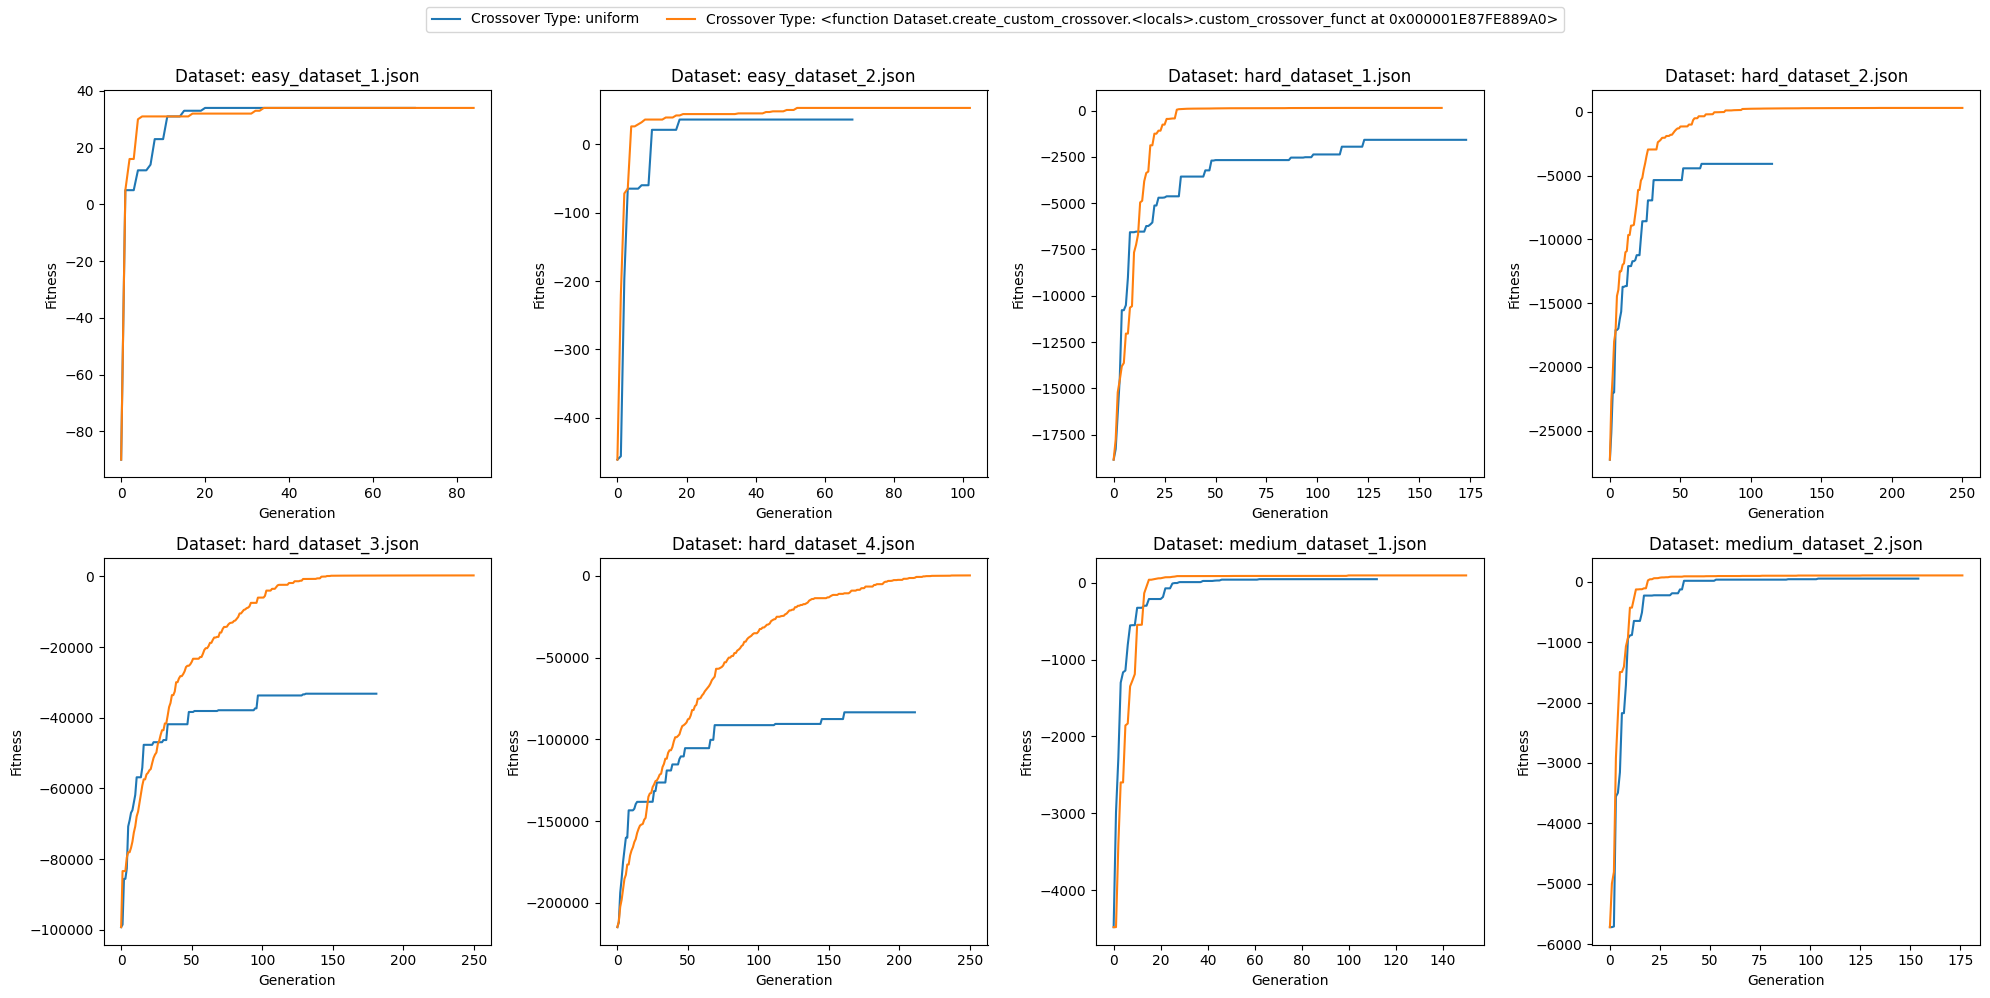

In [15]:

    
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for i, (key, dataset) in enumerate(data.items()):
    print(key)
    fitness_function = dataset.fitness_function
    costum_mutation = dataset.costum_mutation
    costum_crossover = dataset.custom_crossover

    mutation_funcs = ["random", costum_mutation]
    crossover_types = ["uniform", costum_crossover]	

    # Plot for different mutation types
    best_solution, fitness_history = run_ga_and_plot_fitness_both(key, 'crossover_type', crossover_types, mutation_funcs, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
    for name in crossover_types:
        axes[i // 4, i % 4].plot(fitness_history[str(name)], label=f"Crossover Type: {name}")
    
    axes[i // 4, i % 4].set_xlabel("Generation")
    axes[i // 4, i % 4].set_ylabel("Fitness")
    axes[i // 4, i % 4].set_title(f"Dataset: {key}")
    fun = dataset.create_solution_is_valid()
    for a in best_solution:
        vect_1 = fun(a, get_sum=False, print_values=True, return_matrix=False)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(mutation_funcs))

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


##### **Advance fitness function**
**Advance fitness function**: makes a new constraint, that friends of the author can not check the paper.

easy_dataset_1.json
easy_dataset_2.json
hard_dataset_1.json
hard_dataset_2.json
hard_dataset_3.json
hard_dataset_4.json
medium_dataset_1.json
medium_dataset_2.json


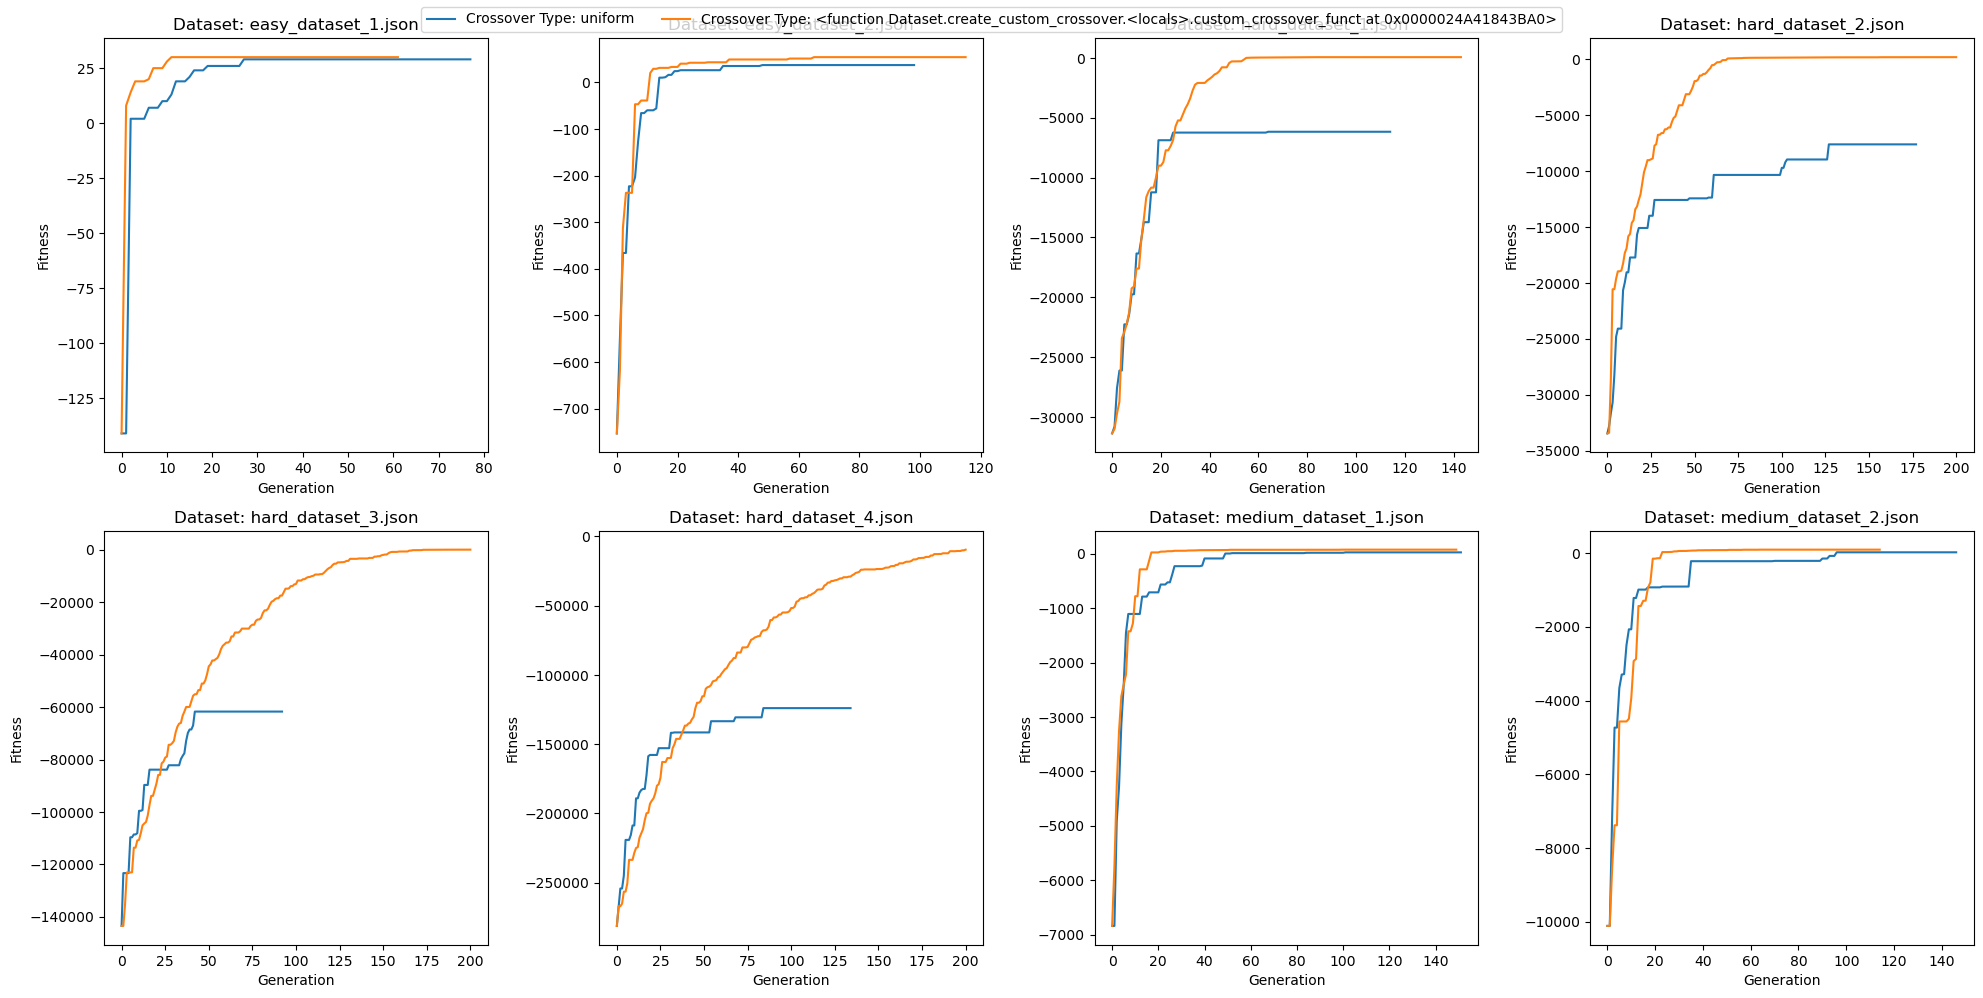

In [124]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for i, (key, dataset) in enumerate(data.items()):
    print(key)
    fitness_function = dataset.fitness_function_advanced
    costum_mutation = dataset.costum_mutation
    costum_crossover = dataset.custom_crossover

    mutation_funcs = ["random", costum_mutation]
    crossover_types = ["uniform", costum_crossover]	

    # Plot for different mutation types
    fitness_history = run_ga_and_plot_fitness_both(key, 'crossover_type', crossover_types, mutation_funcs, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
    for name in crossover_types:
        axes[i // 4, i % 4].plot(fitness_history[str(name)], label=f"Crossover Type: {name}")
    
    axes[i // 4, i % 4].set_xlabel("Generation")
    axes[i // 4, i % 4].set_ylabel("Fitness")
    axes[i // 4, i % 4].set_title(f"Dataset: {key}")

# Create a single legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(mutation_funcs))

plt.tight_layout()
plt.show()